Preperation of the data before feading it into a cNN.

In [60]:
import pandas as pd
df = pd.read_csv("/Users/nabin/python/projects/Sheep Classification Images/train_labels.csv")
if 'index' in df.columns:
    df = df.drop(columns=['index'])

df['file_path'] = "/Users/nabin/python/projects/Sheep Classification Images/train/" + df['filename']



In [62]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

In [79]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define your generators
'''these are the augemtaion that are goona be performed in the training set rember no augmentation is performed in
the valideation set that the second block of the code'''
train_datagen = ImageDataGenerator(
    rescale=1./255, # rescales pixel values from 0–255 to 0–1 for normalization (better training)
    rotation_range=10,# range of augementaion
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.05,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Flow from dataframe
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='file_path',
    y_col='label',
    target_size=(224, 224), # Resize every image to 224x224 (standard for CNNs like ResNet)
    class_mode='categorical',
    batch_size=32,
    shuffle=True
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='file_path',
    y_col='label',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 545 validated image filenames belonging to 7 classes.
Found 137 validated image filenames belonging to 7 classes.


### Visualization of a batch.

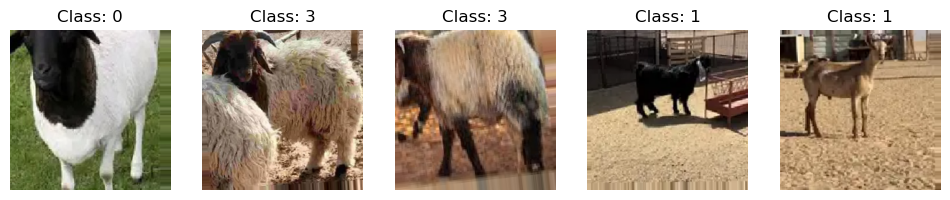

In [95]:
import matplotlib.pyplot as plt

# Grab one batch
images, labels = next(train_generator)

# Plot first 5 images
plt.figure(figsize=(12,6))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(images[i])
    plt.axis('off')
    plt.title("Class: " + str(labels[i].argmax()))
plt.show()

### Neural network tests

In [128]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping


# 1. Load pre-trained ResNet50 base (exclude top)
base_model = ResNet50(
    include_top=False,
    weights='imagenet',
    input_tensor=Input(shape=(224, 224, 3))
)

# 2. Freeze the base model
base_model.trainable = False

### added at 3rd CNN test.
for layer in base_model.layers:
    layer.trainable = False
for layer in base_model.layers[-30:]:
    layer.trainable = True
    
# 3. Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(7, activation='softmax')(x)  # 7 classes

model = Model(inputs=base_model.input, outputs=output)



# 4. Compile
## comple
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# learing rate scheduler 
## added in the 3rd tets
lr_reduce = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5, verbose=1)

# added in the 4th test
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

model.summary()
''' 
<tet 1 and 2 params>

Total params: 23,850,887 (90.98 MB)
Trainable params: 263,175 (1.00 MB)
Non-trainable params: 23,587,712 (89.98 MB)
 
 <tets 3 params and 4 params>

Total params: 23,850,887 (90.98 MB)
Trainable params: 14,713,351 (56.13 MB)
Non-trainable params: 9,137,536 (34.86 MB)

 
'''

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,850,887 (90.98 MB)

 Trainable params: 14,713,351 (56.13 MB)

 Non-trainable params: 9,137,536 (34.86 MB)

' \n<tet 1 and 2 params>\n\nTotal params: 23,850,887 (90.98 MB)\nTrainable params: 263,175 (1.00 MB)\nNon-trainable params: 23,587,712 (89.98 MB)\n \n <tets 3 params>\n\nTotal params: 23,850,887 (90.98 MB)\nTrainable params: 14,713,351 (56.13 MB)\nNon-trainable params: 9,137,536 (34.86 MB)\n\n \n'

## 1st CNN 

In [100]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator)
)

Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


18/18 ━━━━━━━━━━━━━━━━━━━━ 62s 3s/step - accuracy: 0.0860 - loss: 2.8832 - val_accuracy: 0.3723 - val_loss: 1.8354
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/10


2025-06-19 00:48:44.682897: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/anaconda3/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2025-06-19 00:48:44.710903: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


18/18 ━━━━━━━━━━━━━━━━━━━━ 62s 3s/step - accuracy: 0.2116 - loss: 2.3272 - val_accuracy: 0.3723 - val_loss: 1.7708
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 5/10


2025-06-19 00:49:46.584709: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


18/18 ━━━━━━━━━━━━━━━━━━━━ 64s 4s/step - accuracy: 0.2875 - loss: 2.0307 - val_accuracy: 0.3723 - val_loss: 1.7819
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 61s 3s/step - accuracy: 0.2633 - loss: 2.0918 - val_accuracy: 0.3796 - val_loss: 1.7855
Epoch 8/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 9/10


2025-06-19 00:51:51.818723: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


18/18 ━━━━━━━━━━━━━━━━━━━━ 63s 3s/step - accuracy: 0.2443 - loss: 2.1438 - val_accuracy: 0.3796 - val_loss: 1.7787
Epoch 10/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00


lets take a look at what the result above tell us as we can see every other epone doenot recive any data which can be seen form
Epoch 2/10
accuracy: 0.0000e+00 - loss: 0.0000e+00
and from Epoch 3/10
we can also see that there is an error of OUT_OF_RANGE: End of sequence error

❗️Explanation in Simple Terms:

Imagine you have a generator that feeds images in batches (like scooping water from a bucket). But you told your model:

“Keep training for 10 days, and expect a fixed number of scoops every day.”

If the bucket doesn’t have enough water (batches), you run out by Day 2. The model is like:

“Uh… where’s the rest of my data?”
So it stops, and gives you 0.000 accuracy/loss.

🤔 why is this happening lets take a deeper look at it

steps_per_epoch = len(train_generator) {this is the reason ther erroe is happening}


🤔 why is the second errror  ## OUT_OF_RANGE hapeening?

This literally means:

“I’ve reached the end of the data — there’s nothing left to load.”

It’s caused by the same thing: you’re manually telling Keras how many steps to run, but the generator runs out before it can satisfy your request.

Absolutely! Here’s a simpler, flow-based version of the notecard that tells the story clearly — like you’re explaining it to yourself later on:

⸻

🧠 Notecard: Why That Weird OUT_OF_RANGE Error Happened in Keras

⸻

🌊 The Flow (Simple Terms):
	1.	We had 545 training images.
	2.	We set batch_size = 32 → so around 18 batches per epoch.
	3.	We told Keras:
“Every epoch, expect exactly 18 batches.” (steps_per_epoch = 18)

⸻

🚨 The Problem:
	•	After the first epoch, the image generator runs out of data.
	•	But Keras still expects another 18 batches for the next epoch.
	•	Since the generator doesn’t automatically reset, it says:
“Sorry, I’ve got nothing left to give!”
→ ❌ OUT_OF_RANGE error.

⸻

✅ The Fix:

Just don’t set steps_per_epoch.
Let Keras figure it out automatically.

Now, every epoch goes like this:
	•	Use all 545 images → split into 18 batches
	•	At end of epoch, generator resets
	•	Images are reshuffled and augmented again
	•	So each epoch = same data, but looks different to the model!

⸻

💡 Final Thought (Keep in Mind):

When using Keras generators like flow_from_dataframe, you usually don’t need to set steps_per_epoch manually — Keras knows what to do!



## 2nd CNN

In [105]:
model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)

Epoch 1/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 63s 3s/step - accuracy: 0.2332 - loss: 2.1638 - val_accuracy: 0.3723 - val_loss: 1.7758
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 55s 3s/step - accuracy: 0.2479 - loss: 2.1227 - val_accuracy: 0.3723 - val_loss: 1.7684
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 59s 3s/step - accuracy: 0.3382 - loss: 2.0038 - val_accuracy: 0.3723 - val_loss: 1.7743
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 61s 3s/step - accuracy: 0.2597 - loss: 2.0357 - val_accuracy: 0.3796 - val_loss: 1.7802
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 60s 3s/step - accuracy: 0.2847 - loss: 2.0450 - val_accuracy: 0.3723 - val_loss: 1.7790
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 56s 3s/step - accuracy: 0.2398 - loss: 2.0154 - val_accuracy: 0.3796 - val_loss: 1.7816
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 57s 3s/step - accuracy: 0.2855 - loss: 1.9953 - val_accuracy: 0.3723 - val_loss: 1.7664
Epoch 8/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 57s 3s/step - accuracy: 0.2996 - loss: 1.9372 - val_accuracy: 0.3723 - val_loss:

🔍 What’s Happening Right Now
	•	You’re using ResNet-50 with only the top (classifier) layers trainable.
	•	The training accuracy is improving, but:
	•	Validation accuracy is stuck.
	•	Loss isn’t decreasing consistently.
	•	You’re using Adam optimizer (adaptive learning rate).

⸻

🧠 Why This Might Be Happening
	1.	Frozen ResNet Layers:
	•	If you only train the top layers, your model might not be adapting to your dataset.
	•	ResNet-50 was trained on ImageNet, which has very different features (dogs, planes, etc.).
	•	Sheep-specific features may be in deeper layers. If they’re frozen, the model can’t adapt.
	2.	Class Imbalance:
	•	If one class dominates, the model may ignore minority classes. Always check distribution with df['label'].value_counts().
	3.	Learning Rate:
	•	Too high → jumps over minima (never converges).
	•	Too low → learns very slowly or gets stuck in poor minima.
	•	Adam adapts learning rates internally, but still, the initial learning_rate matters.
	4.	Batch Size:
	•	A smaller batch size (like 16) gives noisier gradients, which helps generalization.
	•	Too small makes training unstable; too large may miss finer details.

## 3rd CNN tets

In [125]:
model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[lr_reduce]
)

Epoch 1/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 82s 4s/step - accuracy: 0.2610 - loss: 1.9565 - val_accuracy: 0.0511 - val_loss: 2.1702 - learning_rate: 1.0000e-04
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 97s 5s/step - accuracy: 0.3995 - loss: 1.7465 - val_accuracy: 0.0584 - val_loss: 2.0837 - learning_rate: 1.0000e-04
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 86s 5s/step - accuracy: 0.3939 - loss: 1.6760 - val_accuracy: 0.0949 - val_loss: 2.0707 - learning_rate: 1.0000e-04
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 102s 6s/step - accuracy: 0.4434 - loss: 1.5440 - val_accuracy: 0.1168 - val_loss: 1.9596 - learning_rate: 1.0000e-04
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 97s 5s/step - accuracy: 0.5068 - loss: 1.4509 - val_accuracy: 0.1825 - val_loss: 1.8763 - learning_rate: 1.0000e-04
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 86s 5s/step - accuracy: 0.5163 - loss: 1.3315 - val_accuracy: 0.4453 - val_loss: 1.6751 - learning_rate: 1.0000e-04
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 89s 5s/step - accuracy: 0.5726 - loss

# 4th CNN test

In [130]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,  # You increased this
    callbacks=[early_stop, lr_reduce]
)

Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 85s 4s/step - accuracy: 0.3204 - loss: 1.8934 - val_accuracy: 0.0584 - val_loss: 2.3350 - learning_rate: 1.0000e-04
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 78s 4s/step - accuracy: 0.3538 - loss: 1.7272 - val_accuracy: 0.0438 - val_loss: 2.1437 - learning_rate: 1.0000e-04
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 69s 4s/step - accuracy: 0.4499 - loss: 1.5041 - val_accuracy: 0.0511 - val_loss: 2.0564 - learning_rate: 1.0000e-04
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 69s 4s/step - accuracy: 0.5344 - loss: 1.3266 - val_accuracy: 0.0657 - val_loss: 1.9789 - learning_rate: 1.0000e-04
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 70s 4s/step - accuracy: 0.4717 - loss: 1.3781 - val_accuracy: 0.1387 - val_loss: 1.8098 - learning_rate: 1.0000e-04
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 68s 4s/step - accuracy: 0.5501 - loss: 1.2816 - val_accuracy: 0.1752 - val_loss: 1.7506 - learning_rate: 1.0000e-04
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 69s 4s/step - accuracy: 0.5369 - loss:

# 5th CNN test